# ***Examen práctico parical 1***
### Luis Eduardo Jiménez del Muro - 21/02/2025
---

## Paqueterías y funciones 

In [3]:
# Paqueterías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Funciones

# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', marker='o', color='cadetblue', ms=4, lw=1)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='red', ms=4, lw=1)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')

# **Información del Dataset**

+ CRIM - per capita crime rate by town

+ ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

+ INDUS - proportion of non-retail business acres per town.

+ CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

+ NOX - nitric oxides concentration (parts per 10 million)

+ RM - average number of rooms per dwelling

+ AGE - proportion of owner-occupied units built prior to 1940

+ DIS - weighted distances to five Boston employment centres

+ RAD - index of accessibility to radial highways

+ TAX - full-value property-tax rate per $10,000

+ PTRATIO - pupil-teacher ratio by town

+ B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

+ LSTAT - % lower status of the population

+ MEDV - Median value of owner-occupied homes in $1000's

# **Análisis Exploratorio**

## *Limpieza de datos*

In [13]:
df = pd.read_csv('Boston.csv')
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [14]:
df = df.drop(columns=['Unnamed: 0'])

In [15]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
dtype: int64

In [16]:
df.nunique()

crim       504
zn          26
indus       76
chas         2
nox         81
rm         446
age        356
dis        412
rad          9
tax         66
ptratio     46
lstat      455
medv       229
dtype: int64

In [17]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### Crear variables dummy

+ A pesar de que los datos que hay en `rad` son numéricos, en realiadad representan categorías sobre la accesibilidad a las carreteras radiales.

+ En cuanto a `chas` no será necesario obtener dummies dado que ya es está en el formato de dummy.

In [18]:
categorical = ['chas', 'rad', 'zn'] # No se elige chas porque ya está en formato de dummy
numerical = df.drop(columns=categorical).columns.tolist()
dummies = ['rad_1', 'rad_2', 'rad_3', 'rad_4', 'rad_5', 'rad_6', 'rad_7', 'rad_8', 'rad_24']

df = pd.get_dummies(df, columns=['rad', 'zn'])
df.head()

,crim,indus,chas,nox,rm,age,dis,tax,ptratio,lstat,...,zn_55.0,zn_60.0,zn_70.0,zn_75.0,zn_80.0,zn_82.5,zn_85.0,zn_90.0,zn_95.0,zn_100.0
0,0.00632,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,4.98,...,False,False,False,False,False,False,False,False,False,False
1,0.02731,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,9.14,...,False,False,False,False,False,False,False,False,False,False
2,0.02729,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,4.03,...,False,False,False,False,False,False,False,False,False,False
3,0.03237,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,2.94,...,False,False,False,False,False,False,False,False,False,False
4,0.06905,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,5.33,...,False,False,False,False,False,False,False,False,False,False


## *Visualización de los datos*

### Scatterplots contra el target

In [19]:
target = 'medv'

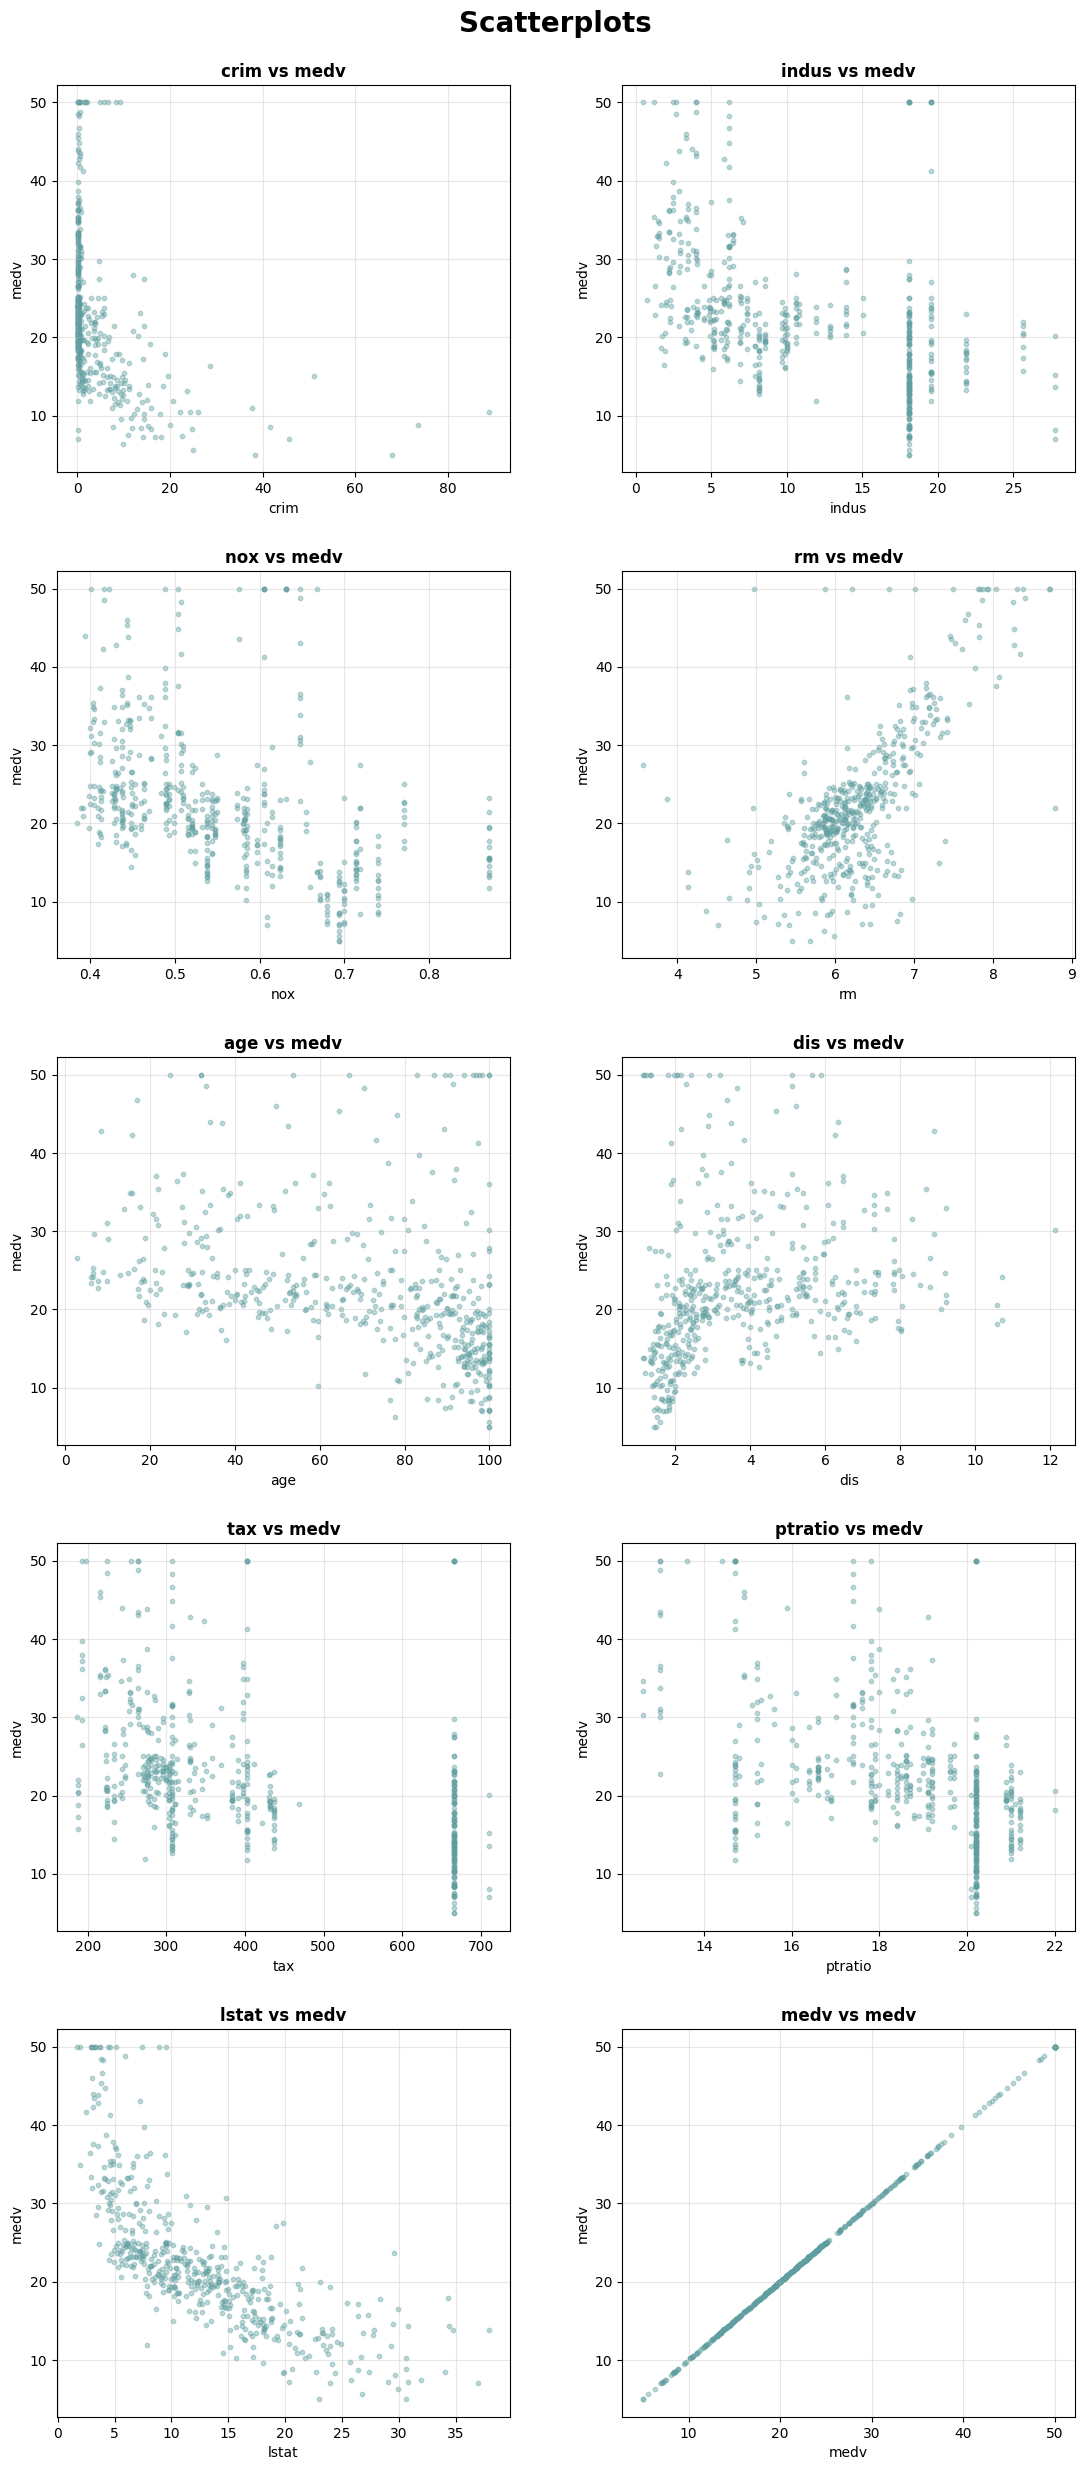

In [ ]:
num_vars = len(numerical) 

fig, axes = plt.subplots(5, 2, figsize=(12, 25))
fig.tight_layout(pad=5)
fig.suptitle('Scatterplots', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        ax.scatter(df[numerical[i]].drop(columns=s), df[target], marker='o', color='cadetblue', s=10, alpha=0.4)
        ax.set_title(f'{numerical[i]} vs {target}', fontsize=12, fontweight='bold')
        ax.set_xlabel(numerical[i])
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones

+ Variables como `lstat` y `rm` son las únicas a las que a simple vista podría parecer que se les puede ajustar una recta o polinomio.

+ `crim` y `zn` tienen una alta concentración de datos en cero.

+ Hay un salto muy grande en `tax` entre $450$ y $650$.

+ Las demás variables presentan mucha dispersión, por lo que, será mejor realizar un análisis bivariado para poder comprender mejor las relaciones con la variable objetivo.

### Análisis bivariado

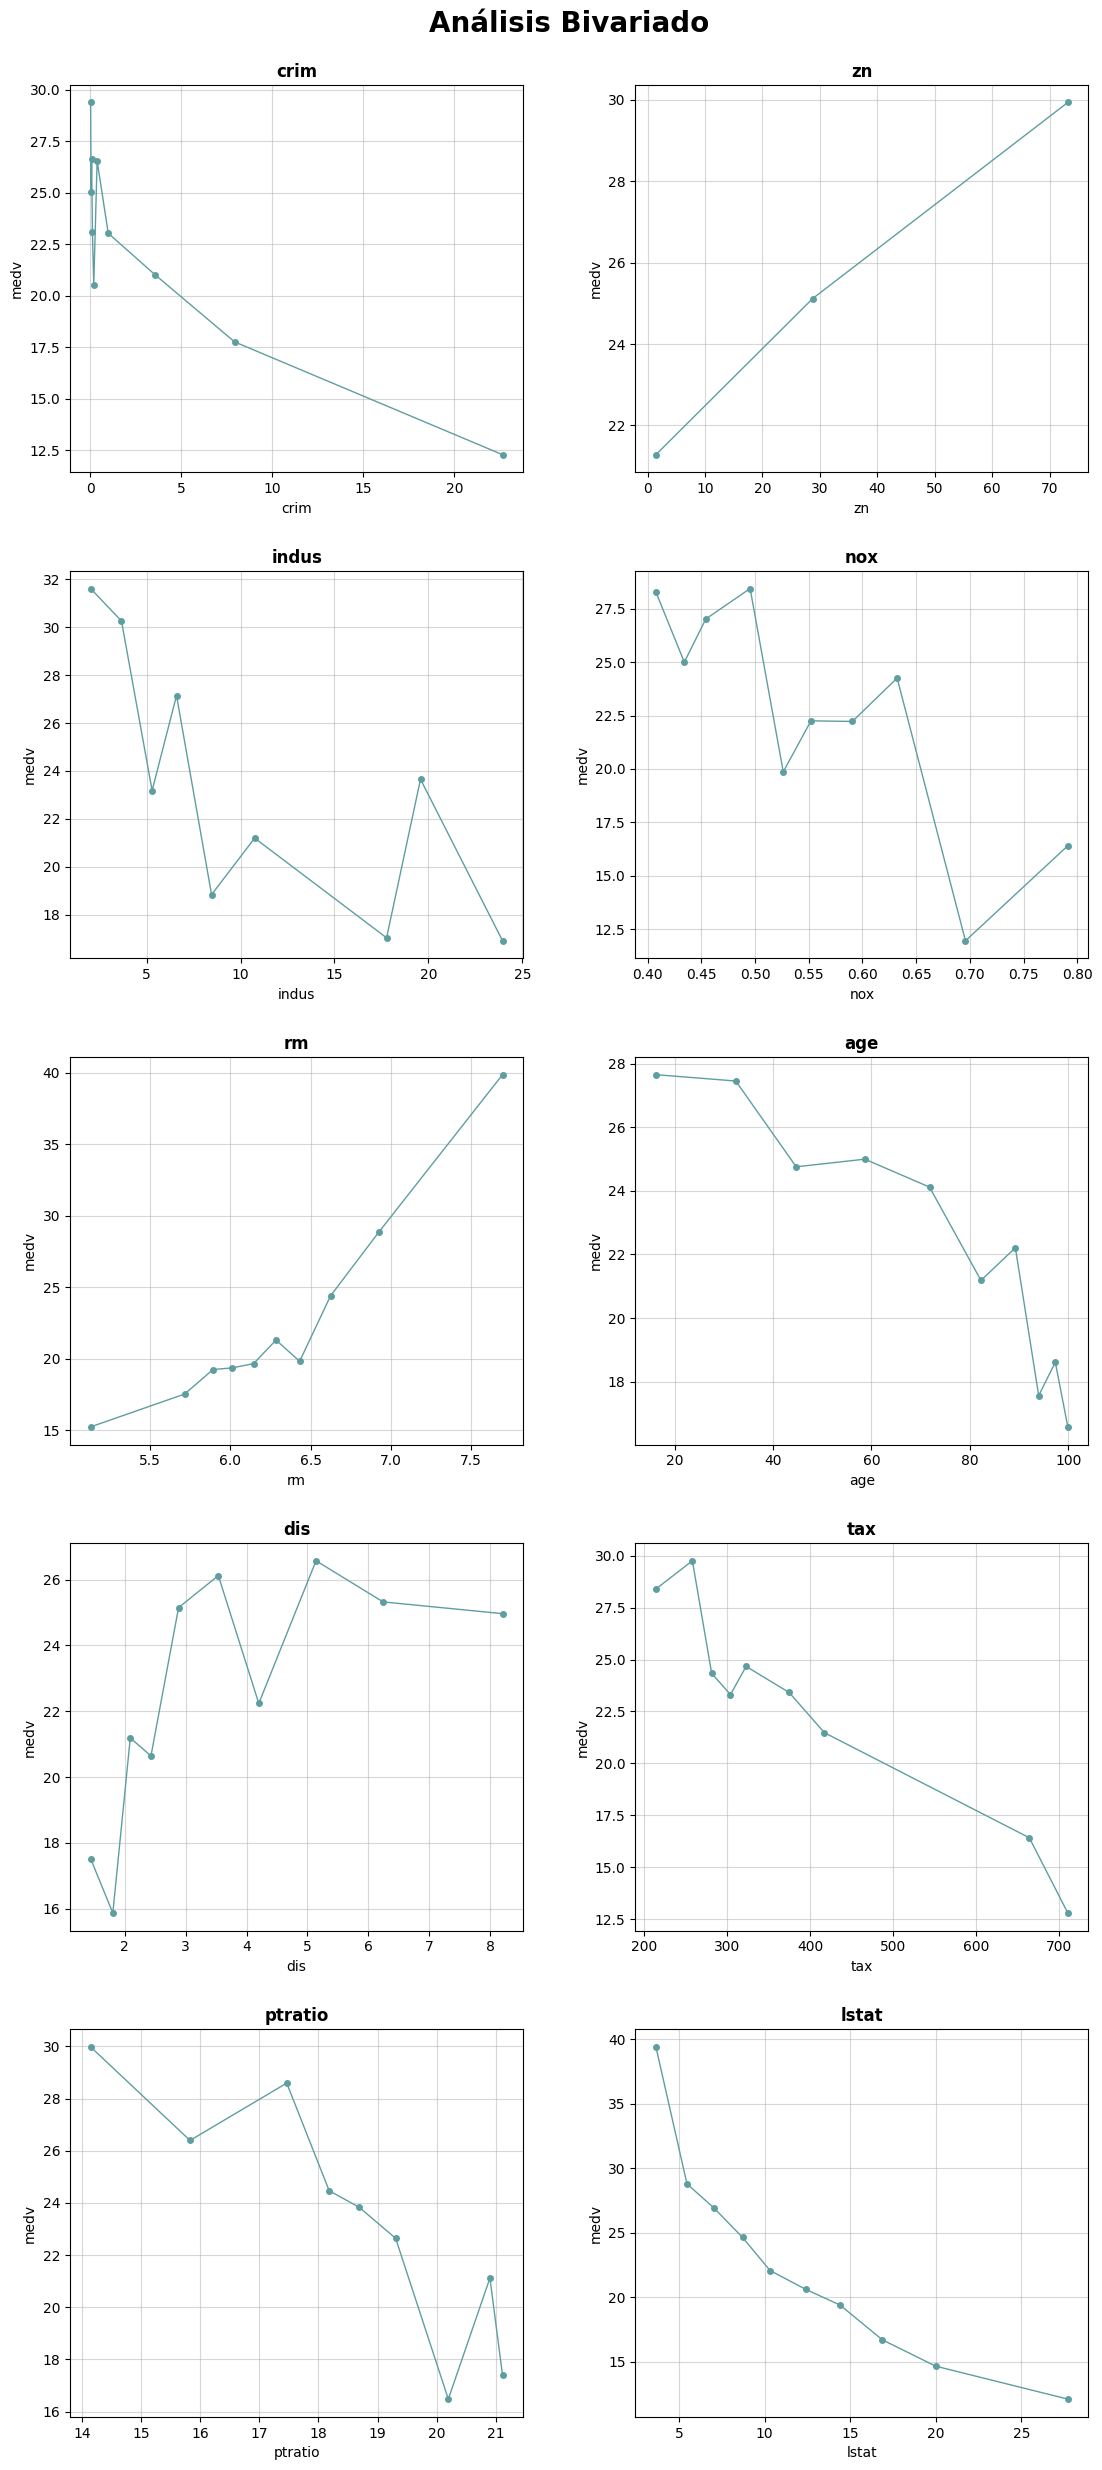

In [12]:
df_bivariado = df.copy()

fig, axes = plt.subplots(5, 2, figsize=(12, 25))
fig.tight_layout(pad=5)
fig.suptitle('Análisis Bivariado', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        df_bivariado[f'{numerical[i]}_bins'] = pd.qcut(df_bivariado[numerical[i]], q=10, labels=False, duplicates='drop') + 1
        grouped_data = df_bivariado.groupby(f'{numerical[i]}_bins').mean()
            
        ax.plot(grouped_data[numerical[i]], grouped_data[target], marker='o', color='cadetblue', lw=1, markersize=4)
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.set_xlabel(numerical[i])
        ax.set_ylabel(target)
        ax.grid(alpha=0.5)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones 

+ Solo hay una variable que se relaciona linealmente con el target de forma muy clara y es `zn`.

+ Variables como `rm` y `tax` tambien, podrían relacionarse linealmente. Sin embargo, podrian intentarse ajustar potencias diferentes.

+ `nox` y `ptratio` son variables con mucha dispersión, por ende, tambien habrá que probar si se ajustan mejor polinomios o rectas.

+ A pesar de que `indus` y `dis` tienen mucha dispersión, pueden relacionarse de forma cuadrática o algun otro grado de polinomio.

+ Con `crim`, `age` y `lstat` se observan relaciones cuadráticas claras.

### Histogramas

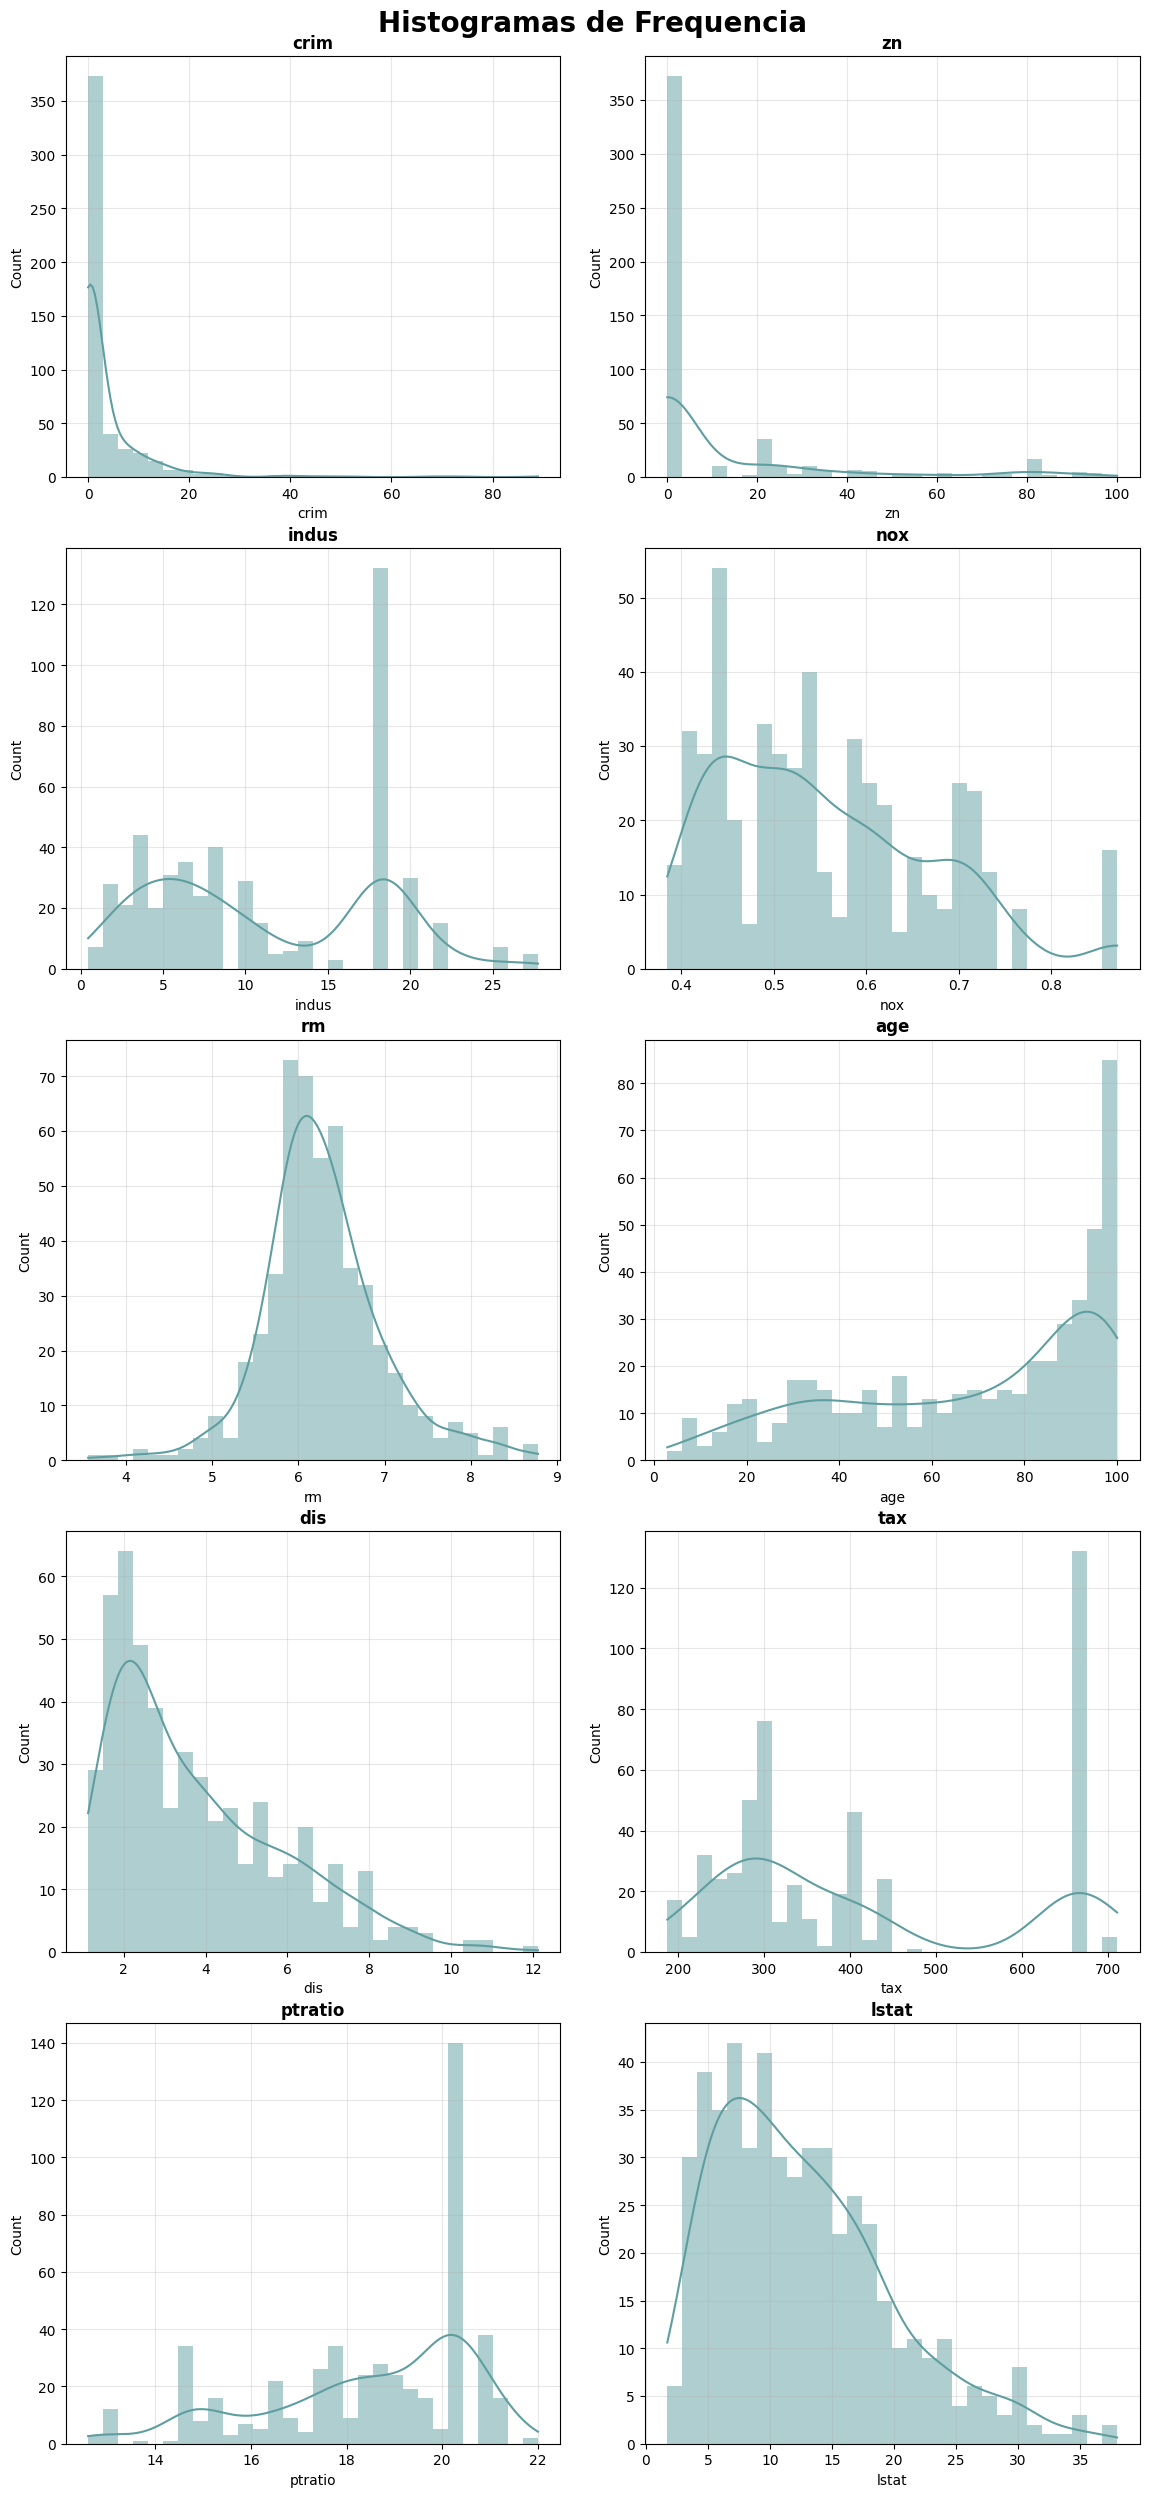

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(12,25))
fig.tight_layout(pad=3)
fig.suptitle('Histogramas de Frequencia', fontsize=20, fontweight='bold', y=1)


for i, ax in enumerate(axes.flat):
    if i < num_vars:
        sns.histplot(df[numerical[i]],  color="cadetblue", kde=True, ax=ax, bins=30,  edgecolor=None)
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos


plt.show()

#### Observaciones

+ Podemos confirmar la alta cantidad de datos que existen en cero en las variables de `crim` y `zn`.

+ Los datos se distribuyen de formas muy diferentes entre sí, por lo que, sería conveniente probar haciendo estandarizaciones.

### Boxplots

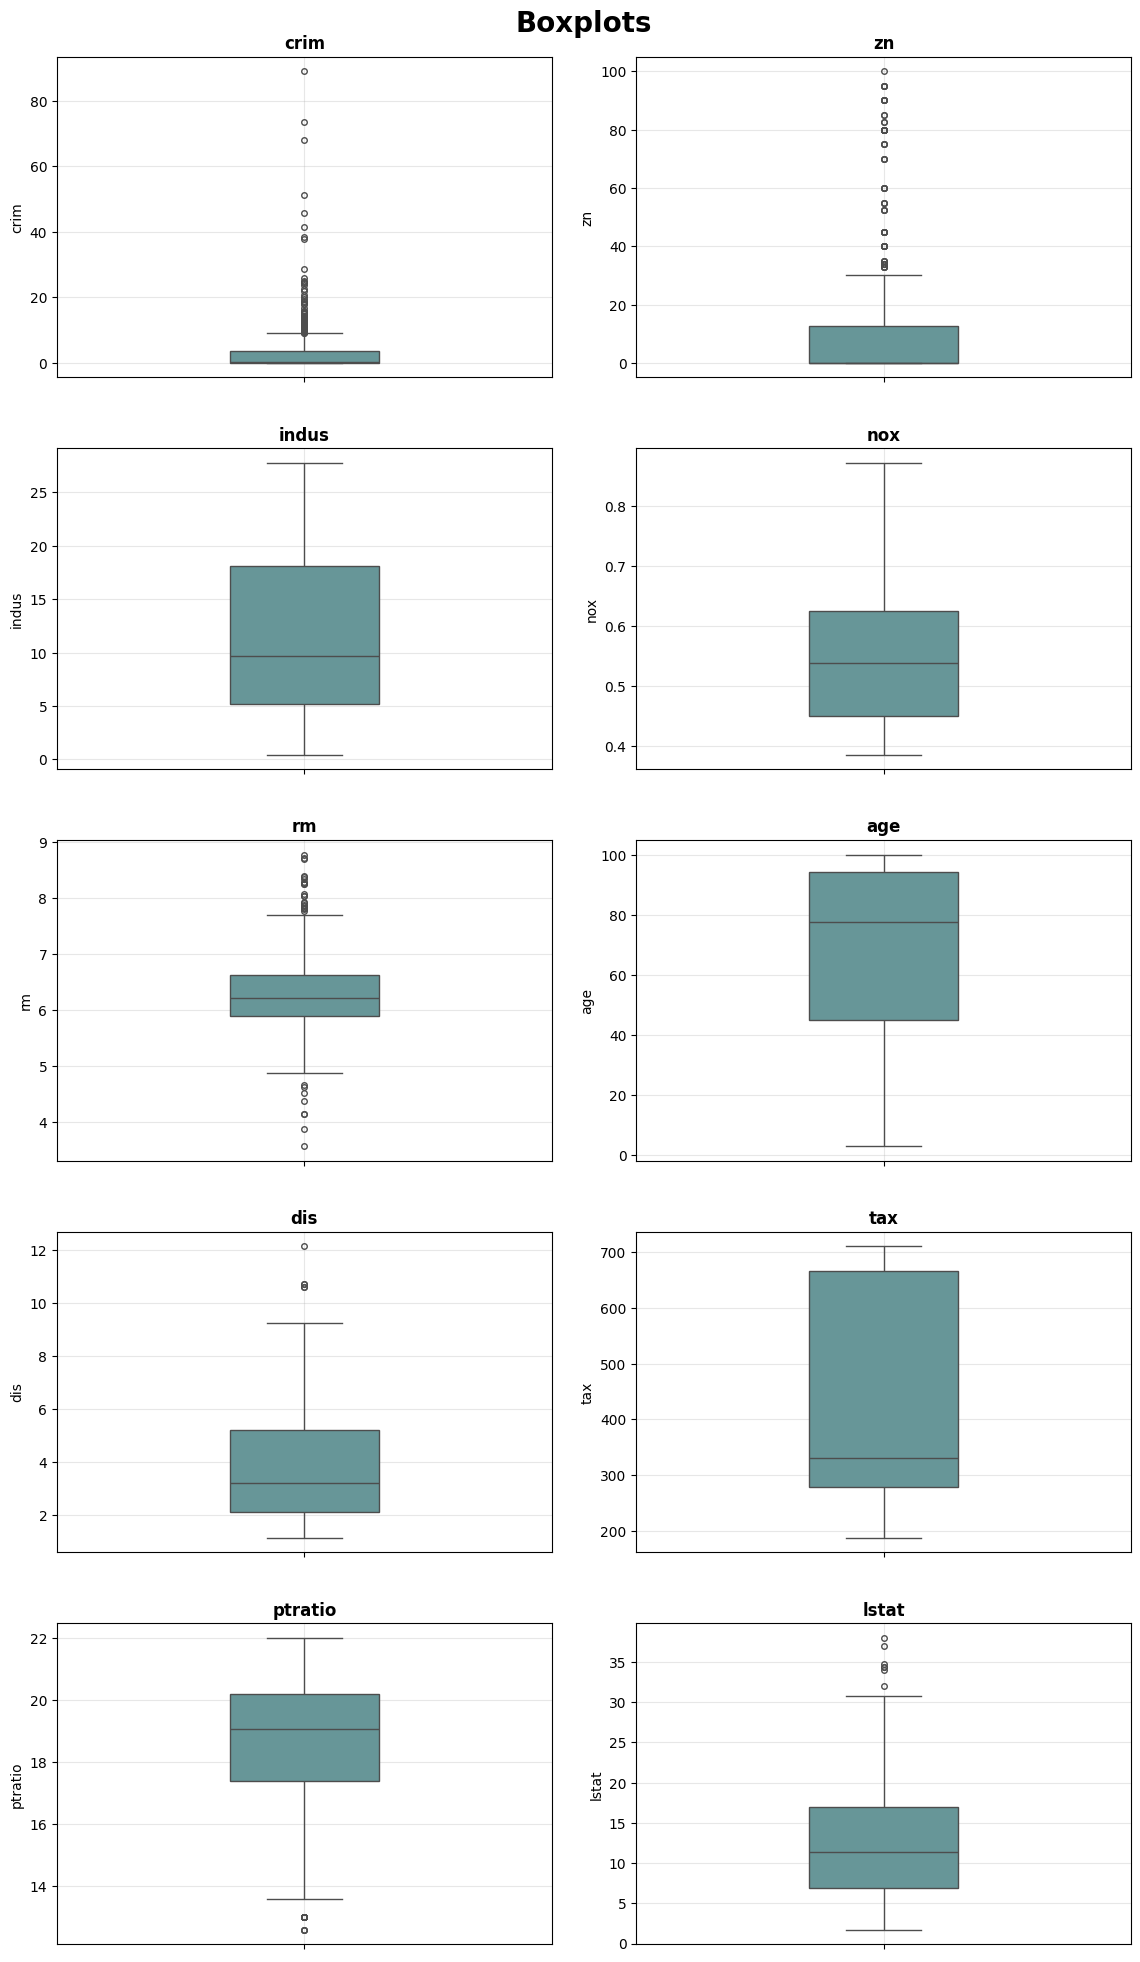

In [321]:
fig, axes = plt.subplots(5, 2, figsize=(12,20))
fig.tight_layout(pad=3)
fig.suptitle('Boxplots', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        sns.boxplot(y=df[numerical[i]], ax=ax, color="cadetblue", width=0.3, flierprops={'marker': 'o', 'markersize': 4})
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones

+ Dada la alta concentración de datos en cero de `crim` y `zn`, observamos que tambien hay muchos outliers, que podrían llegar a darle información importante al modelo, o incluso perjudicarlo.

+ `rm`, `dis`, `lstat` y `ptratio` tambien presentan outliers.

+ Al momento de hacer modelos, harán prubeas controlando y no controlando los outliers para ver como modifican el desempeño del modelo. Por ejemplo, al momento de hacer estandarización, controlar los datos que sean menores a $-3$ y mayores a $3$.

## *Matriz de Correlaciones*

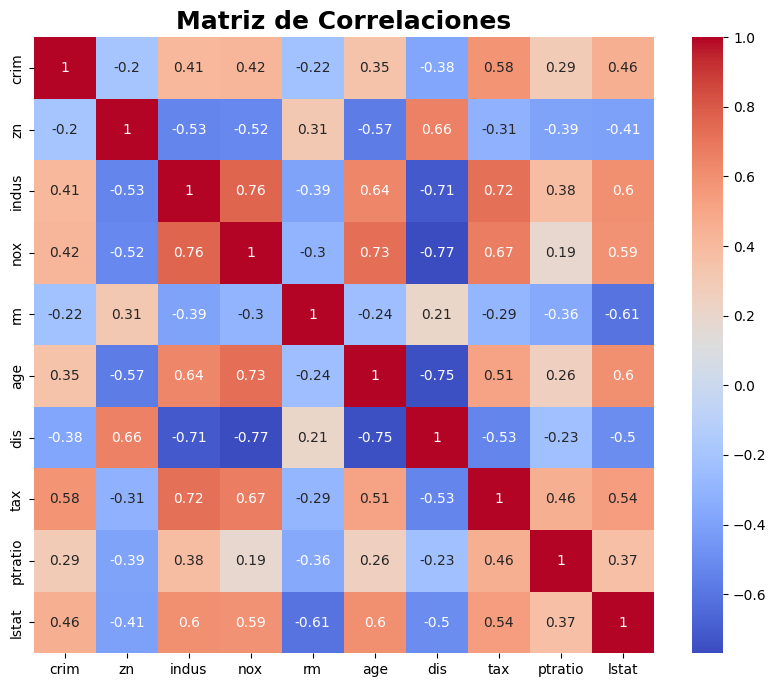

In [322]:
df_corr = pd.read_csv('Boston.csv').drop(columns=['Unnamed: 0', target, 'chas', 'rad'])
plt.figure(figsize=(10,8))
sns.heatmap(df_corr.corr().round(2), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaciones', fontsize=18, fontweight='bold')
plt.show()

#### Observaciones

La mayoría de las variables están conrrelacionadas, sin embargo, nos enfocaremos en aquellos pares que un coeficente de correlación mayor 70%:
1. `nox` - `indus`.
2. `age` - `nox`.
3. `dis` - `indus`.
4. `dis` - `nox`.
5. `tax` - `indus`.

## *Feature Engeneering*

En esta sección se crearán nuevas variables y modificarán algunas de las actuales. Además se crearan __ nuevos dataframes que contengan diferentes combinaciones de las nuevas variables con las originales, para probar el desempeño de los modelos utilizando y sin utilizar estas variables

### Modificación de variables actuales variables

Como observamos en las gráficas del análisis exploratorio, podemos modificar algunas de nuestras variables para tratar de controlar los datos atípicos, y tambien corregir las relaciones polinómicas que tienen algunas variables con el target. Entonces se proponen las siguientes modificaciones de variables:

* `rm`: potencia 2.
* `tax`: potencia 2.
* `nox`: potencia 2.
* `ptratio`: potencia 2.
* `indus`: potencia 2.
* `crim`: potencia 2.
* `age`: potencia 2.
* `lstat`: potencia 2.
* `rm`: logaritmo natural.

### Creación de nuevas variables

A partir de los datos que se tienen, es posible proponer nuevas variables porque hace sentido relacionarlas unas on otras:

* `crim / indus`: Relación entre criminalidad y zonas industriales.
* `crim / lstat`: Relación entre criminalidad y % de estatus inferior de la población.
* `rm / lstat`: Relación entre promedio de habitaciones y % de estatus inferior de la población.
* `nox / indus`: Relación entre la concentración de óxidos nítricos de habitaciones y zonas industriales.
* `nox / dis`: Relación entre la concentración de óxidos nítricos de habitaciones y las distancias a los centros de empleo.
* `age / lstat`: Relación entre la las casas ocupadas que se construyeron antes de 1940 y el % de status inferior de la población.
* `tax / rm`: Relación entre los impuestos y la cantidad de habitaciones.
* `tax / lstat`: Los impuestos y el % de status inferior de la población.
* `ptratio / rm`: Relación entre la educación y las gabitaciones promedio.
* `ptratio / nox`: Relación entre la educación y la concentración de óxidos nítricos.
* `ptratio / dis`: Relación entre la educación y la distancia a los centros de empleo.

Además, se crearán nuevas variables que relacionen aquellos pares con correlación superior al 70% y que no se repitan con las que ya se definieron utilizando el sentido común:
* `nox / age`.
* `dis / indus`.
* `tax / indus`.

### Creación de los nuevos DataFrames

In [323]:
# Variables modificadas
modified_features_df = pd.DataFrame()
modified_features_df['rm_2'] = df['rm']**2
modified_features_df['tax_2'] = df['tax']**2
modified_features_df['nox_2'] = df['nox']**2
modified_features_df['ptratio_2'] = df['ptratio']**2
modified_features_df['indus_2'] = df['indus']**2
modified_features_df['crim_2'] = df['crim']**2
modified_features_df['age_2'] = df['age']**2
modified_features_df['lstat_2'] = df['lstat']**2
modified_features_df['ln_dist'] = np.log(1+df['dis']) # +1 para evitar ln(0)

# Nuevas variables
new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])
new_features_df['nox_age'] = df['nox'] / (1+df['age'])
new_features_df['dis_indus'] = df['dis'] / (1+df['indus'])
new_features_df['tax_indus'] = df['tax'] / (1+df['indus'])

# Nuevos dataframes para futuras pruebas
df_mod_plus_originals = pd.concat([df, modified_features_df], axis=1)
df_new_feat_plus_originals = pd.concat([df, new_features_df], axis=1)
df_all_new_plus_originals = pd.concat([df, modified_features_df, new_features_df], axis=1)
df_all_new_not_originals = pd.concat([df[['medv']], modified_features_df, new_features_df], axis=1)

## *Feature Selection*

Ahora, analizaremos principalmente lo significativas que son nuestras variables para el modelo, y tomar decisiones de descartarlas o dejarlas. Para ello, se usarán las pruebas de hipótesis de `statsmodel`.

### Significancia de las variables originales

En primera instancia revisaremos cuales de las variables originales son realmente significativas al momento de predecir el target. 

Para el proceso de seleccionar las variables, se eliminaran de una por una, para verificar los P-Value cada que eliminemos a la que tenga menor significancia. El orden en el que están acomodadas las variables al momento de definir las variables independientes, es como se fueron descartando, para al final quedar con un modelo con puras variables significativas.

In [324]:
independent_vars = '+'.join(df.columns.difference([target, 'indus', 'age', 'rad_1', 'rad_6','rad_2']))

# Guardar las variables para usarlas en el futura al momento de probar modelos
sign_original_variables = df.columns.difference([target, 'indus', 'age', 'rad_1', 'rad_6','rad_2'])

regresion = f"{target} ~ {independent_vars}"

# Ajustar el modelo de regresión lineal
result = smf.ols(formula=regresion, data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,41.7323,5.082,8.212,0.000,31.747,51.718
rad_24[T.True],6.0159,1.434,4.195,0.000,3.198,8.834
rad_3[T.True],3.6712,0.988,3.716,0.000,1.730,5.613
rad_4[T.True],1.6252,0.758,2.143,0.033,0.135,3.115
rad_5[T.True],1.8333,0.768,2.386,0.017,0.324,3.343
rad_7[T.True],3.9458,1.317,2.995,0.003,1.358,6.534
rad_8[T.True],3.7931,1.173,3.233,0.001,1.488,6.098
chas,2.6619,0.863,3.085,0.002,0.967,4.357
crim,-0.1233,0.033,-3.769,0.000,-0.188,-0.059
dis,-1.6216,0.189,-8.561,0.000,-1.994,-1.249


### Significancia de las variables creadas en Feature Engeneering

Ahora probaremos la significancia de las nuevas variables por si solas contra el target. Sin incluir en la regresión a las variables originales. El proceso de selección de variables, es el mismo que en el análisis anterior.

In [325]:
independent_vars = '+'.join(df_all_new_not_originals.columns.difference([target, 'nox_dis', 'ptratio_nox',
                                                                         'rm_lstat', 'indus_2', 'crim_2',
                                                                         'ptratio_dis', 'lstat_2', 'nox_age',
                                                                         'age_lstat', 'tax_rm', 'dis_indus']))

# Guardar las variables para usarlas en el futura al momento de probar modelos
sign_new_variables = df_all_new_not_originals.columns.difference([target, 'nox_dis', 'ptratio_nox',
                                                                         'rm_lstat', 'indus_2', 'crim_2',
                                                                         'ptratio_dis', 'lstat_2', 'nox_age',
                                                                         'age_lstat', 'tax_rm', 'dis_indus'])

regresion = f"{target} ~ {independent_vars}"

# Ajustar el modelo de regresión lineal
result = smf.ols(formula=regresion, data=df_all_new_not_originals).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-14.5991,5.304,-2.752,0.006,-25.021,-4.177
age_2,-0.0003,8.23e-05,-3.159,0.002,-0.000,-9.83e-05
crim_indus,-6.6512,1.226,-5.427,0.000,-9.059,-4.243
crim_lstat,4.2601,1.215,3.507,0.000,1.873,6.647
ln_dist,-4.6158,0.840,-5.493,0.000,-6.267,-2.965
nox_2,-13.9655,2.224,-6.279,0.000,-18.335,-9.596
nox_indus,113.3322,13.017,8.706,0.000,87.756,138.908
ptratio_2,-0.0838,0.008,-10.858,0.000,-0.099,-0.069
ptratio_rm,16.8481,1.939,8.688,0.000,13.038,20.658
rm_2,0.7391,0.060,12.282,0.000,0.621,0.857


### Significancia de todas las variables

Ahora que se encontraron todas las variables que son significativas, se realizará una nueva prueba utilizando todas las variables que se encontraron como significativas y ver si hay que hacer nuevas eliminaciones. Nuevamente se sigue la misma metodología de eliminación de variables

In [326]:
all_sign_variables = sign_new_variables.tolist() + sign_original_variables.tolist()

independent_vars = '+'.join(df_all_new_plus_originals[all_sign_variables].columns.difference([target, 'tax', 'nox_2', 
                                                                                              'zn', 'ptratio_2', 'rm_2',
                                                                                              'crim', 'lstat', 'dis', 'rad_5',
                                                                                              'rad_4', 'rad_7', 'rad_8']))

all_sign_variables = df_all_new_plus_originals[all_sign_variables].columns.difference([target, 'tax', 'nox_2', 
                                                                                              'zn', 'ptratio_2', 'rm_2',
                                                                                              'crim', 'lstat', 'dis', 'rad_5',
                                                                                              'rad_4', 'rad_7', 'rad_8'])

formula = f"{target} ~ {independent_vars}"

# Ajustar el modelo de regresión lineal
result = smf.ols(formula=formula, data=df_all_new_plus_originals).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-31.1376,7.658,-4.066,0.000,-46.183,-16.092
rad_24[T.True],2.7641,1.202,2.300,0.022,0.402,5.126
rad_3[T.True],1.3878,0.647,2.145,0.032,0.116,2.659
age_2,-0.0003,8.22e-05,-3.141,0.002,-0.000,-9.67e-05
chas,1.6936,0.649,2.610,0.009,0.419,2.968
crim_indus,-6.6925,1.203,-5.565,0.000,-9.055,-4.330
crim_lstat,3.9880,1.191,3.348,0.001,1.648,6.328
ln_dist,-5.3070,0.852,-6.226,0.000,-6.982,-3.632
nox,-19.2100,2.984,-6.437,0.000,-25.074,-13.346
nox_indus,93.7720,14.172,6.617,0.000,65.927,121.617


## *Prueba de modelos*

### Regresión lineal múltiple con los datos originales + dummies.

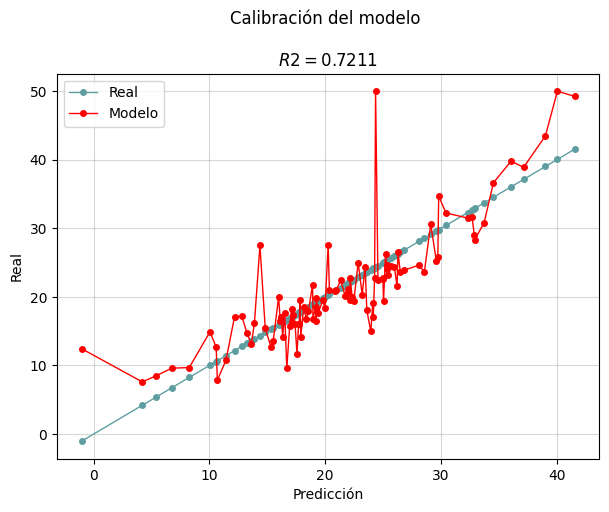

In [329]:
X = df.copy().drop(columns=target)
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

### Regresión polinómica grado 2 con los datos originales + dummies.

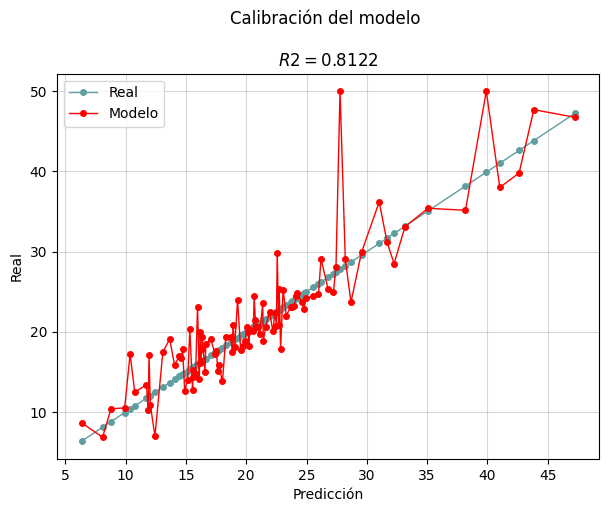

In [330]:
X = df.copy().drop(columns=target)
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Regresión polinómica grado 3 con los datos originales + dummies.

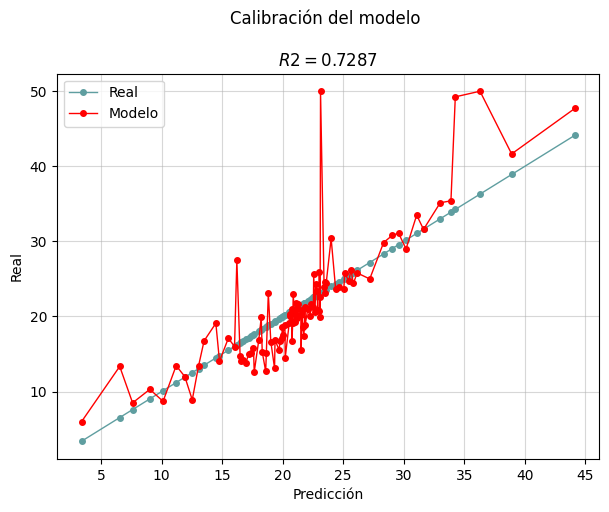

In [331]:
X = df.copy().drop(columns=target)
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Regresión lineal múltiple con las variables originales que son significativas.

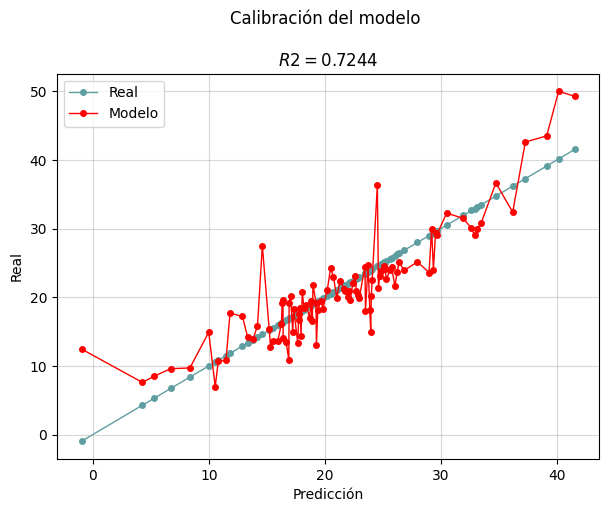

In [332]:
X = df[sign_original_variables].copy()
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

### Regresión polinomial grado 2 con las variables originales que son significativas.

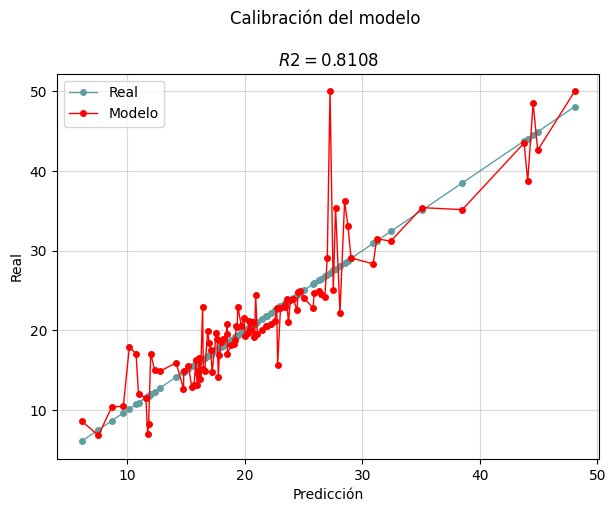

In [333]:
X = df[sign_original_variables].copy()
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Regresión lineal múltiple con todas las variables significativas creadas, sin las originales.

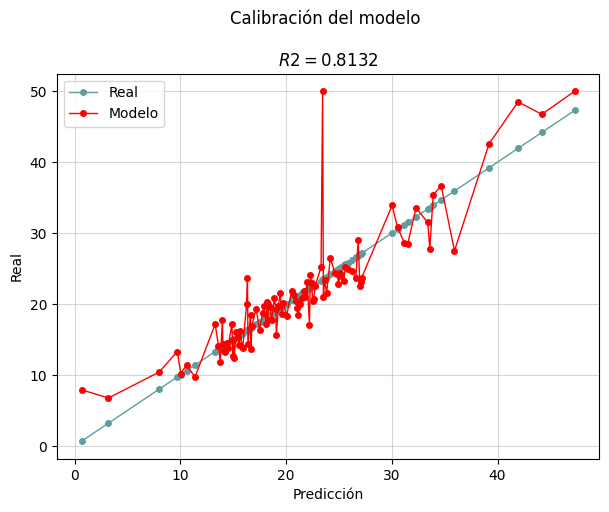

In [334]:
X = df_all_new_not_originals[sign_new_variables.tolist()]
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

### Regresión lineal polinomial grado 2 con todas las variables significativas creadas, sin las originales.

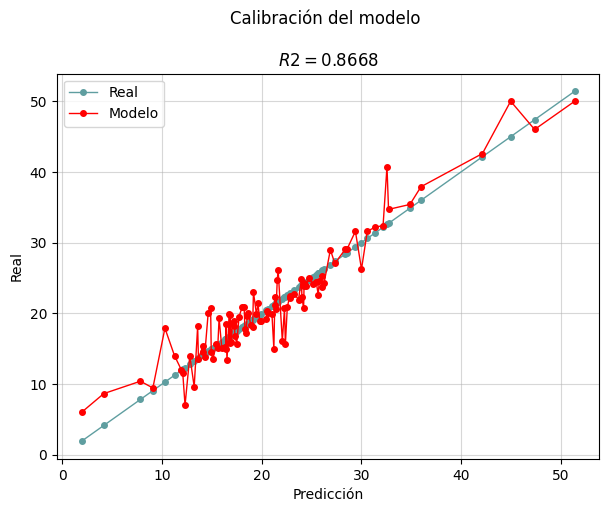

In [335]:
X = df_all_new_not_originals[sign_new_variables.tolist()]
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Regresión lineal múltiple con todas las variables significativas, originales y creadas.

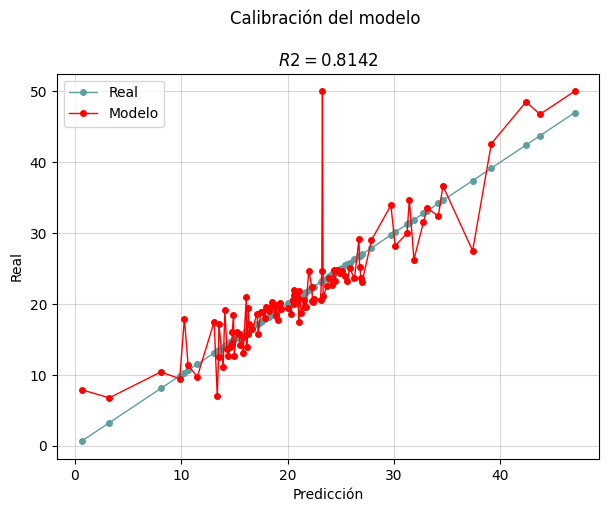

In [336]:
X = df_all_new_plus_originals[all_sign_variables.tolist()]
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

### Regresión lineal polinomica grado 2 con todas las variables significativas, originales y creadas.

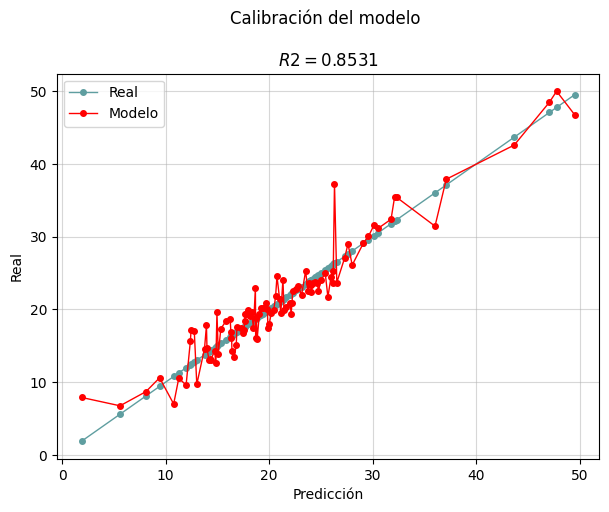

In [337]:
X = df_all_new_plus_originals[all_sign_variables.tolist()]
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Regresión lineal múltiple con todas las variables creadas y originales, sin eliminar las no significativas.

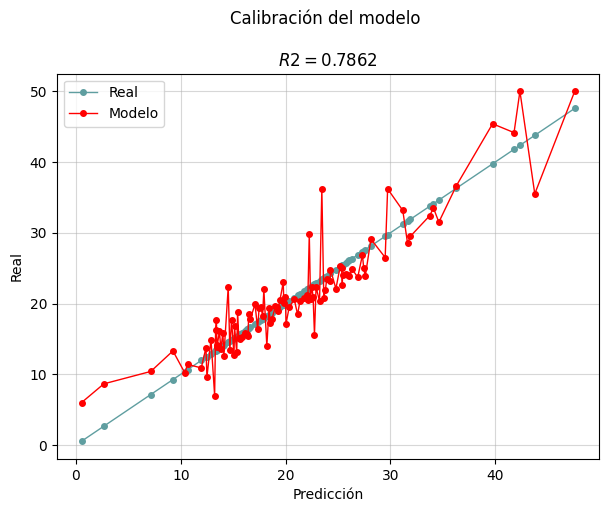

In [338]:
X = df_all_new_plus_originals.copy().drop(columns={target})
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

### Regresión lineal múltiple con todas las variables creadas y originales, sin eliminar las no significativas.

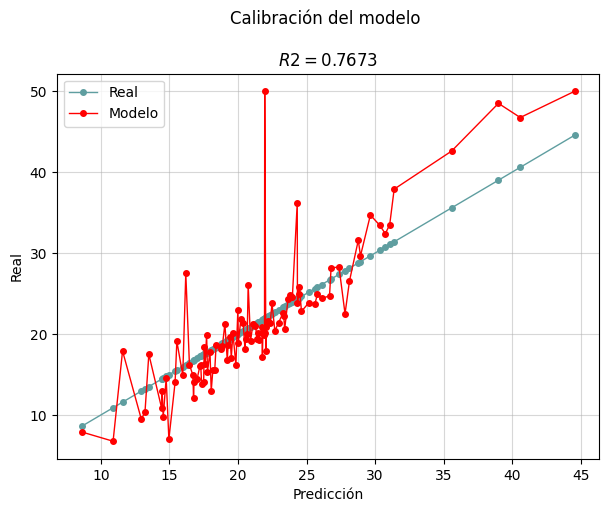

In [339]:
X = df_all_new_plus_originals.copy().drop(columns={target})
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 100)

#### Observaciones

### Conclusiones hasta el momento.

* El mejor modelo de regresión lineal múltiple hasta ahora es en el que se usan todas las variables significativas creadas sin tomar en cuenta las originales.

* El mejor modelo de regresión polinomica hasta ahora es en el polinomio de grado 2 que usa todas las variables significativas creadas sin tomar en cuenta las originales.

### Ultima propuesta de modelos

Antes de escoger al mejor modelo, se realizará una última prueba, en donde se tomarán los mejores modelos hasta ahora y se crean variables categóricas a partir de las numéricas, creando bins y posteriormente crear dummies de estos bins.

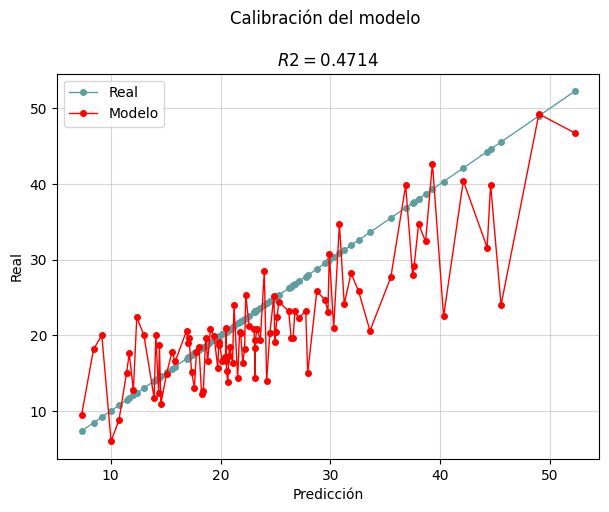

In [340]:
X = df_all_new_not_originals[sign_new_variables.tolist()]
y = df[target]

numerical_features = df_all_new_not_originals[sign_new_variables.tolist()].columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin']=pd.qcut(X[var], q=bins, labels=False, duplicates='drop')
    return X

X_train = create_bins(X_train, numerical_features, 10)
X_test = create_bins(X_test, numerical_features, 10)


bin_features = [i for i in X_train.keys() if 'bin' in i]

X_train = pd.get_dummies(X_train[bin_features], columns=bin_features)
X_test = pd.get_dummies(X_test[bin_features], columns=bin_features)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 100)

#### Observaciones

#### Observaciones

#### Observaciones

In [356]:
df_all_new_not_originals[sign_new_variables.tolist()]

,age_2,crim_indus,crim_lstat,ln_dist,nox_2,nox_indus,ptratio_2,ptratio_rm,rm_2,tax_2,tax_indus,tax_lstat
0,4251.04,0.001909,0.001057,1.627278,0.289444,0.162538,234.09,2.019802,43.230625,87616,89.425982,49.498328
1,6225.21,0.003384,0.002693,1.786261,0.219961,0.058116,316.84,2.398599,41.229241,58564,29.987608,23.865878
2,3733.21,0.003382,0.005425,1.786261,0.219961,0.058116,316.84,2.174710,51.624225,58564,29.987608,48.111332
3,2097.64,0.010179,0.008216,1.954757,0.209764,0.144025,349.69,2.338085,48.972004,49284,69.811321,56.345178
4,2937.64,0.021714,0.010908,1.954757,0.209764,0.144025,349.69,2.295323,51.079609,49284,69.811321,35.071090
...,...,...,...,...,...,...,...,...,...,...,...,...
501,4774.81,0.004844,0.005870,1.246630,0.328329,0.044316,441.00,2.765705,43.467649,74529,21.113689,25.585754
502,5882.89,0.003501,0.004491,1.190127,0.328329,0.044316,441.00,2.949438,37.454400,74529,21.113689,27.083333
503,8281.00,0.004699,0.009151,1.152943,0.328329,0.044316,441.00,2.632899,48.664576,74529,21.113689,41.114458
504,7974.49,0.008476,0.014651,1.220505,0.328329,0.044316,441.00,2.694380,46.158436,74529,21.113689,36.497326
